# VIX-Adjusted Momentum (US)

Replicating [VIX-Adjusted Momentum](https://cssanalytics.wordpress.com/2014/07/29/vix-adjusted-momentum/)

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

indices <- Indices()

In [2]:
startDate <- as.Date('1990-01-02')
endDate <- as.Date('2019-06-30')

vixDt <- indices$YahooFinanceTimeSeries() %>%
    filter(NAME == '^VIX' & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))
    
sp500Dt <- indices$YahooFinanceTimeSeries() %>%
    filter(NAME == '^GSPC' & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

allXts <- merge(sp500Xts <- xts(sp500Dt$CLOSE, sp500Dt$TIME_STAMP), xts(vixDt$CLOSE, vixDt$TIME_STAMP))
names(allXts) <- c('SP500', 'VIX')


In [3]:
allXts$SMA_200 <- SMA(allXts$SP500, 200)
allXts$D_RET <- dailyReturn(allXts$SP500)
allXts$D_RET_LAG_1 <- stats::lag(allXts$D_RET, -1) #signal is generated and traded at the close, so use next day's return

allXts$VIX_ADJ_RET <- allXts$D_RET/allXts$VIX
allXts$VIX_ADJ_RET_SMA_200 <- SMA(allXts$VIX_ADJ_RET, 200) 

allXts$ROC_200 <- rollapply(allXts$D_RET, 200, Return.cumulative) #simple compound return or ROC (rate of change) 

allXts <- na.omit(allXts)
print(head(allXts))
print(tail(allXts))

            SP500   VIX  SMA_200         D_RET   D_RET_LAG_1    VIX_ADJ_RET
1990-10-15 303.23 31.64 338.9269  0.0106656001 -0.0142136332  0.00033709229
1990-10-16 298.92 31.45 338.6230 -0.0142136332 -0.0005352603 -0.00045194382
1990-10-17 298.76 31.37 338.3230 -0.0005352603  0.0233632347 -0.00001706281
1990-10-18 305.74 29.60 338.0734  0.0233632347  0.0220448747  0.00078929847
1990-10-19 312.48 27.86 337.8748  0.0220448747  0.0072964670  0.00079127332
1990-10-22 314.76 27.27 337.6796  0.0072964670 -0.0076248570  0.00026756388
           VIX_ADJ_RET_SMA_200    ROC_200
1990-10-15     -0.000016508169 -0.1569685
1990-10-16     -0.000018767888 -0.1689510
1990-10-17     -0.000018142493 -0.1672427
1990-10-18     -0.000011955366 -0.1403829
1990-10-19     -0.000005573282 -0.1127768
1990-10-22     -0.000005349599 -0.1103197
             SP500   VIX  SMA_200        D_RET  D_RET_LAG_1    VIX_ADJ_RET
2019-06-20 2954.18 14.75 2775.676  0.009472161 -0.001259199  0.00064218040
2019-06-21 2950.46 15.40

In [4]:
#go long only if the index is above its 200-day average
allXts$SMA_STRAT <- ifelse(allXts$SP500 > allXts$SMA_200, allXts$D_RET_LAG_1, 0) 

#go long only if the simple average (VIX-Adjusted Momentum) > 0
allXts$VIX_STRAT <- ifelse(allXts$VIX_ADJ_RET_SMA_200 > 0, allXts$D_RET_LAG_1, 0) 

#go long only if the ROC > 0
allXts$ROC_200_STRAT <- ifelse(allXts$ROC_200 > 0, allXts$D_RET_LAG_1, 0)

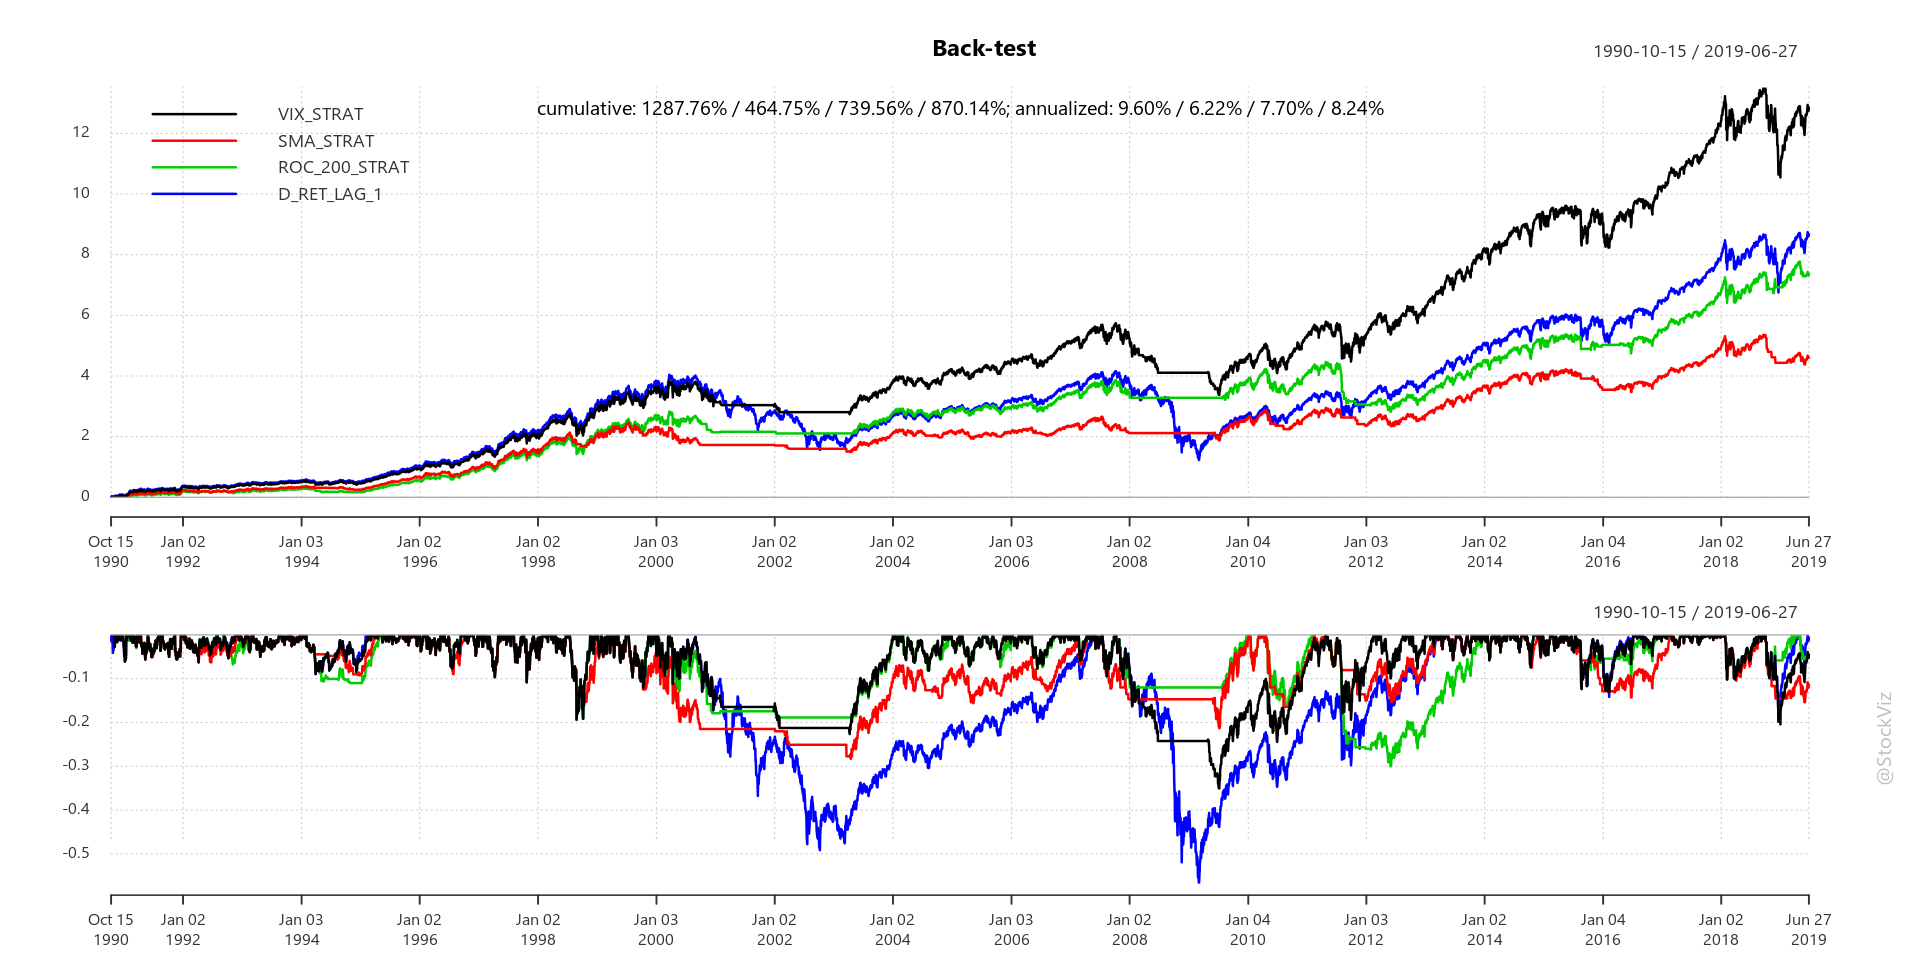

In [5]:
#plot returns
toPlot <- merge(allXts$VIX_STRAT, allXts$SMA_STRAT, allXts$ROC_200_STRAT, allXts$D_RET_LAG_1)
Common.PlotCumReturns(toPlot, "Back-test", "")

In [6]:
#calculate annual returns

byYearDf <- data.frame(T=0, VIX_MOM=0.0, SMA=0.0, ROC=0.0, BH=0.0)

allYears <- unique(year(index(allXts)))
for(yr in allYears){
    byYearDf <- rbind(byYearDf,
                    c(yr, as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'VIX_STRAT'])),
                        as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'SMA_STRAT'])),
                        as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'ROC_200_STRAT'])),
                        as.numeric(100.0*Return.cumulative(allXts[toString(yr), 'D_RET_LAG_1']))))
}

byYearDf <- byYearDf[-1,]
print(byYearDf)

      T     VIX_MOM         SMA         ROC          BH
2  1990   4.6817380   0.0000000  -1.0548012   7.6575537
3  1991  27.8174299  22.9999715  20.8826331  27.8174299
4  1992   4.3426161   0.9446372  -0.8932926   4.3426161
5  1993   6.9043135   6.9043135   6.9043135   6.9043135
6  1994  -2.6431332  -6.0458197  -7.8313671  -1.3600034
7  1995  35.2028926  35.2028926  34.4560932  35.2028926
8  1996  18.7327824  15.4624206  18.7327824  18.7327824
9  1997  32.2967124  32.2967124  32.2967124  32.2967124
10 1998  25.9538070  16.6552324  25.9538070  25.9538070
11 1999  18.4936080   9.6203377  18.4936080  18.4936080
12 2000  -9.2728247 -17.2444803 -14.6314053 -11.8160828
13 2001  -3.8787419   0.0000000   0.5461161 -10.0212738
14 2002  -5.2162176  -4.5917781  -1.7230061 -21.2736106
15 2003  25.3994249  18.9596505  20.9734803  21.9409700
16 2004   8.4439954   2.6248868   3.8981833   8.4439954
17 2005   5.5503793  -0.6675703   1.5997103   5.5503793
18 2006  11.6488020   5.7373831  11.0394827  11.

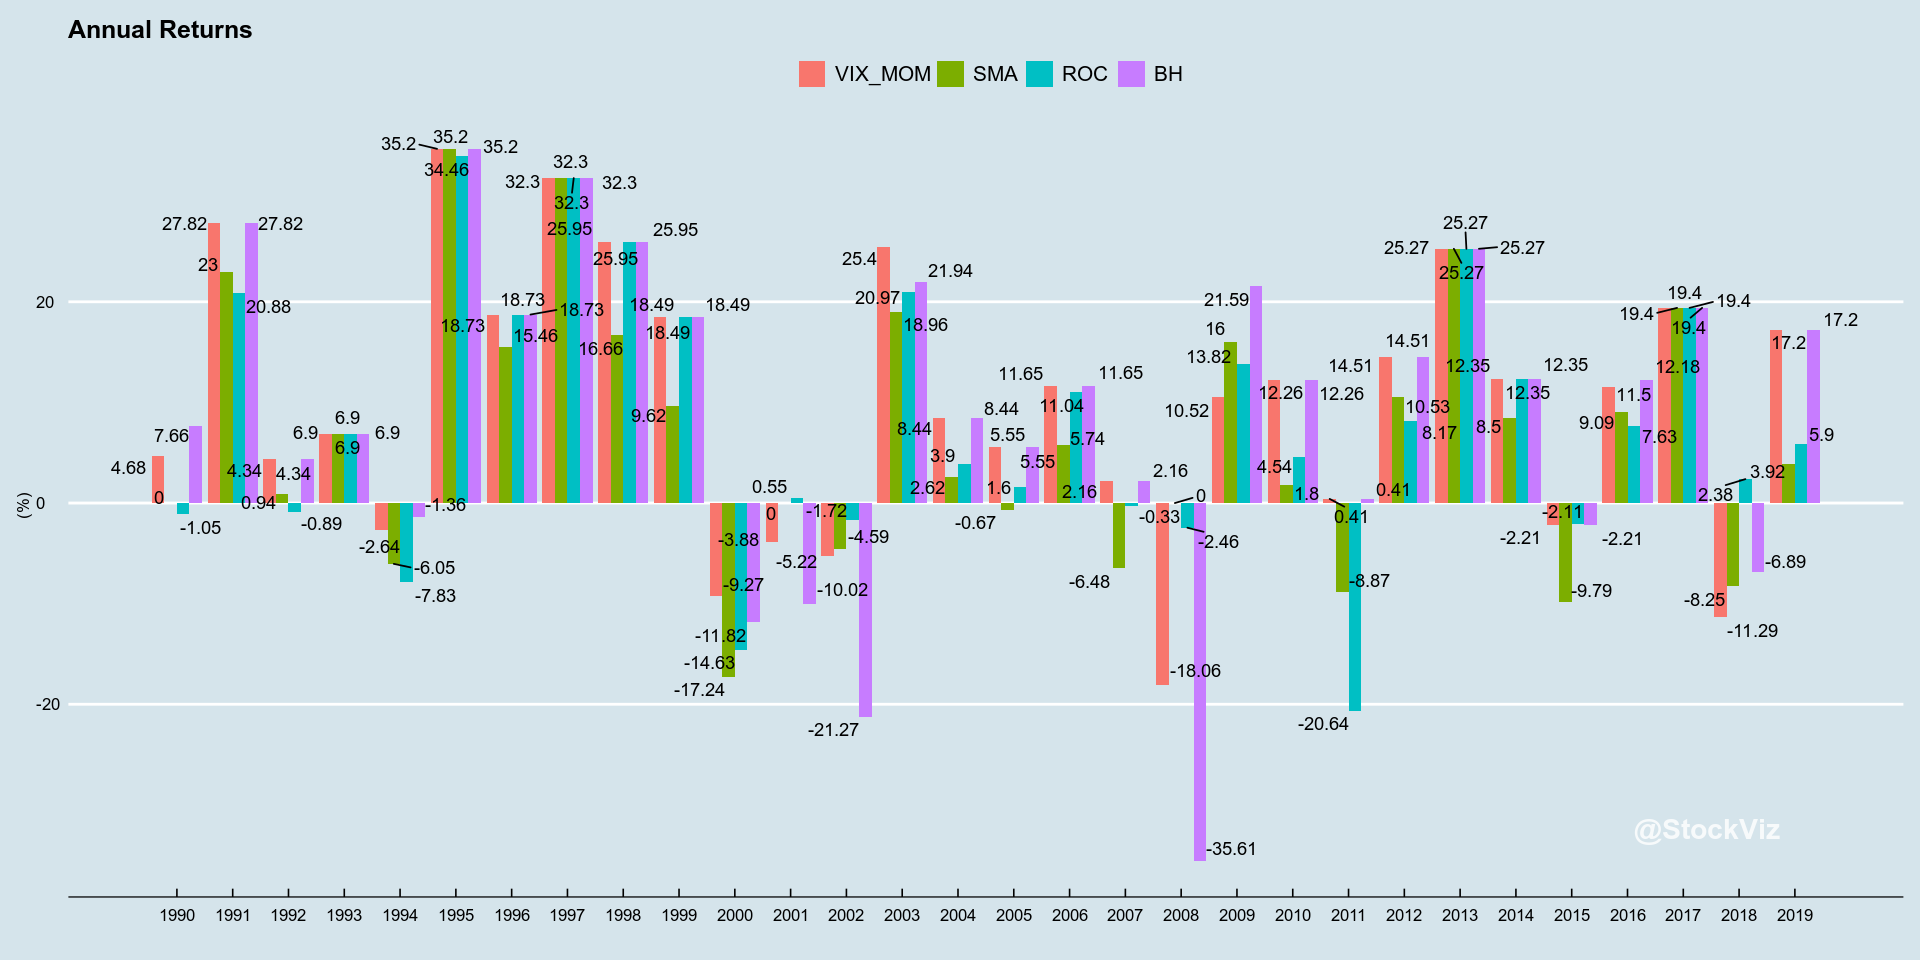

In [7]:
#plot annual returns

ggplot(melt(byYearDf, id='T'), aes(x=T, y=value, fill=variable)) +
    theme_economist() +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=byYearDf$T, breaks=byYearDf$T) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=sprintf("Annual Returns")) +
    annotate("text", x=max(byYearDf$T), y=min(sapply(byYearDf[,-1], min, na.rm=T)), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)